# Portfolio Optimization

“Modern Portfolio Theory (MPT), a hypothesis put forth by Harry Markowitz in his paper “Portfolio Selection,” (published in 1952 by the Journal of Finance) is an investment theory based on the idea that risk-averse investors can construct portfolios to optimize or maximize expected return based on a given level of market risk, emphasizing that risk is an inherent part of higher reward. It is one of the most important and influential economic theories dealing with finance and investment.

## Monte Carlo Simulation for Optimization Search

We could randomly try to find the optimal portfolio balance using Monte Carlo simulation

In this notebook I have tried to apply this portfolio optimization to indian car's stock data(maruti, mahindra and mahindra,tata motors, bajaj motors.

I have used quandl to get stock data (Daily Close value) from 1st Jan 2013 to 1st Jan 2018.

Open for feedback. :)

*warning :  This code is a simulation and done for educational purpose and results calculated are not accurate to real results. Please use this code as educational resource only.*

In [2]:
import quandl
import pandas as pd
import numpy as np
import datetime
#import os
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
maruti = pd.read_csv('data/maruti_close.csv',index_col='Date',parse_dates=True)
mahindra = pd.read_csv('data/mahindra_close.csv',index_col='Date',parse_dates=True)
tata = pd.read_csv('data/tata_close.csv',index_col='Date',parse_dates=True)
bajaj = pd.read_csv('data/bajaj_close.csv',index_col='Date',parse_dates=True)

In [4]:
stocks = pd.concat([maruti,mahindra,tata,bajaj],axis=1)
stocks.columns = ['maruti','mahindra','tata','bajaj']

In [5]:
stocks.head()

,maruti,mahindra,tata,bajaj
Date,,,,
2013-01-01,1514.40,941.80,316.75,2131.90
2013-01-02,1557.40,938.60,318.00,2202.25
2013-01-03,1543.30,936.40,318.10,2214.90
2013-01-04,1545.45,941.25,315.40,2205.60
2013-01-07,1584.60,954.15,313.25,2196.90


In [6]:
mean_daily_ret = stocks.pct_change(1).mean()
mean_daily_ret

maruti      0.001630
mahindra    0.000115
tata        0.000474
bajaj       0.000460
dtype: float64

In [7]:
stocks.pct_change(1).corr()

,maruti,mahindra,tata,bajaj
maruti,1.000000,0.278428,0.330917,0.351222
mahindra,0.278428,1.000000,0.264439,0.270191
tata,0.330917,0.264439,1.000000,0.315236
bajaj,0.351222,0.270191,0.315236,1.000000


# Simulating Thousands of Possible Allocations

In [8]:
stocks.head()

,maruti,mahindra,tata,bajaj
Date,,,,
2013-01-01,1514.40,941.80,316.75,2131.90
2013-01-02,1557.40,938.60,318.00,2202.25
2013-01-03,1543.30,936.40,318.10,2214.90
2013-01-04,1545.45,941.25,315.40,2205.60
2013-01-07,1584.60,954.15,313.25,2196.90


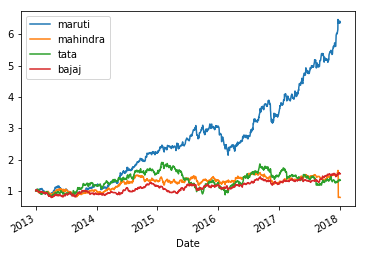

In [9]:
stock_normed = stocks/stocks.iloc[0]
stock_normed.plot()

In [10]:
stock_daily_ret = stocks.pct_change(1)
stock_daily_ret.head()

,maruti,mahindra,tata,bajaj
Date,,,,
2013-01-01,NaN,NaN,NaN,NaN
2013-01-02,0.028394,-0.003398,0.003946,0.032999
2013-01-03,-0.009054,-0.002344,0.000314,0.005744
2013-01-04,0.001393,0.005179,-0.008488,-0.004199
2013-01-07,0.025332,0.013705,-0.006817,-0.003945


## Log Returns vs Arithmetic Returns

We will now switch over to using log returns instead of arithmetic returns, for many of our use cases they are almost the same,but most technical analyses require detrending/normalizing the time series and using log returns is a nice way to do that.
Log returns are convenient to work with in many of the algorithms we will encounter.

For a full analysis of why we use log returns, check [this great article](https://quantivity.wordpress.com/2011/02/21/why-log-returns/).

In [11]:
log_ret = np.log(stocks/stocks.shift(1))
log_ret.head()

,maruti,mahindra,tata,bajaj
Date,,,,
2013-01-01,NaN,NaN,NaN,NaN
2013-01-02,0.027998,-0.003404,0.003939,0.032466
2013-01-03,-0.009095,-0.002347,0.000314,0.005728
2013-01-04,0.001392,0.005166,-0.008524,-0.004208
2013-01-07,0.025017,0.013612,-0.006840,-0.003952


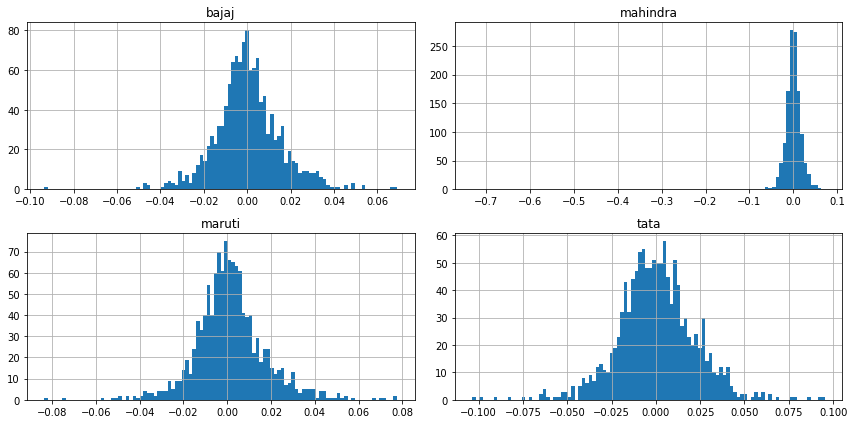

In [12]:
log_ret.hist(bins=100,figsize=(12,6));
plt.tight_layout()

In [13]:
log_ret.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
maruti,1237.0,0.001497,0.016219,-0.083456,-0.007616,0.000594,0.009315,0.077470
mahindra,1237.0,-0.000190,0.026429,-0.731055,-0.009370,0.000037,0.009620,0.071948
tata,1237.0,0.000237,0.021786,-0.103544,-0.012320,-0.000155,0.012605,0.095367
bajaj,1237.0,0.000351,0.014782,-0.093440,-0.007981,-0.000412,0.007964,0.069022


In [14]:
log_ret.mean() * 252

maruti      0.377315
mahindra   -0.047849
tata        0.059625
bajaj       0.088342
dtype: float64

In [15]:
# Compute pairwise covariance of columns
log_ret.cov()

,maruti,mahindra,tata,bajaj
maruti,0.000263,0.000101,0.000118,0.000085
mahindra,0.000101,0.000698,0.000127,0.000089
tata,0.000118,0.000127,0.000475,0.000102
bajaj,0.000085,0.000089,0.000102,0.000219


## Single Run for Some Random Allocation

In [16]:
# Set seed (optional)
np.random.seed(101)

# Stock Columns
print('Stocks')
print(stocks.columns)
print('\n')

# Create Random Weights
print('Creating Random Weights')
weights = np.array(np.random.random(4))
print(weights)
print('\n')

# Rebalance Weights
print('Rebalance to sum to 1.0')
weights = weights / np.sum(weights)
print(weights)
print('\n')

# Expected Return
print('Expected Portfolio Return')
exp_ret = np.sum(log_ret.mean() * weights) *252
print(exp_ret)
print('\n')

# Expected Variance
print('Expected Volatility')
exp_vol = np.sqrt(np.dot(weights.T, np.dot(log_ret.cov() * 252, weights)))
print(exp_vol)
print('\n')

# Sharpe Ratio
SR = exp_ret/exp_vol
print('Sharpe Ratio')
print(SR)

Stocks
Index(['maruti', 'mahindra', 'tata', 'bajaj'], dtype='object')


Creating Random Weights
[0.51639863 0.57066759 0.02847423 0.17152166]


Rebalance to sum to 1.0
[0.40122278 0.44338777 0.02212343 0.13326603]


Expected Portfolio Return
0.1432635313085147


Expected Volatility
0.24824020423331442


Sharpe Ratio
0.5771165543106994


Great! Now we can just run this many times over!

In [17]:
num_ports = 15000

all_weights = np.zeros((num_ports,len(stocks.columns)))
ret_arr = np.zeros(num_ports)
vol_arr = np.zeros(num_ports)
sharpe_arr = np.zeros(num_ports)

for ind in range(num_ports):

    # Create Random Weights
    weights = np.array(np.random.random(4))

    # Rebalance Weights
    weights = weights / np.sum(weights)
    
    # Save Weights
    all_weights[ind,:] = weights

    # Expected Return
    ret_arr[ind] = np.sum((log_ret.mean() * weights) *252)

    # Expected Variance
    vol_arr[ind] = np.sqrt(np.dot(weights.T, np.dot(log_ret.cov() * 252, weights)))

    # Sharpe Ratio
    sharpe_arr[ind] = ret_arr[ind]/vol_arr[ind]

In [18]:
sharpe_arr.max()

1.4316466476913032

In [19]:
sharpe_arr.argmax()

1247

In [20]:
all_weights[1247,:]

array([0.87193323, 0.00853593, 0.00258882, 0.11694202])

In [21]:
max_sr_ret = ret_arr[1247]
max_sr_vol = vol_arr[1247]

## Plotting the data

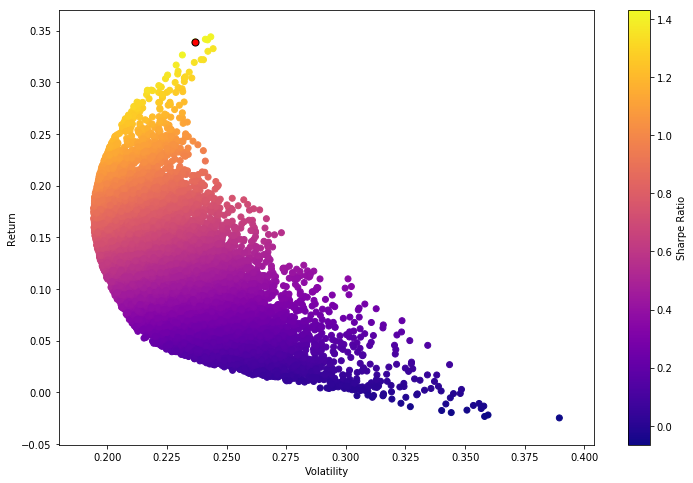

In [22]:
plt.figure(figsize=(12,8))
plt.scatter(vol_arr,ret_arr,c=sharpe_arr,cmap='plasma')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')

# Add red dot for max SR
plt.scatter(max_sr_vol,max_sr_ret,c='red',s=50,edgecolors='black')

# Mathematical Optimization

There are much better ways to find good allocation weights than just guess and check! We can use optimization functions to find the ideal weights mathematically!

### Functionalize Return and SR operations

In [23]:
def get_ret_vol_sr(weights):
    """
    Takes in weights, returns array or return,volatility, sharpe ratio
    """
    weights = np.array(weights)
    ret = np.sum(log_ret.mean() * weights) * 252
    vol = np.sqrt(np.dot(weights.T, np.dot(log_ret.cov() * 252, weights)))
    sr = ret/vol
    return np.array([ret,vol,sr])

In [24]:
from scipy.optimize import minimize

To fully understand all the parameters, check out:
https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html

In [25]:
help(minimize)

Help on function minimize in module scipy.optimize._minimize:

minimize(fun, x0, args=(), method=None, jac=None, hess=None, hessp=None, bounds=None, constraints=(), tol=None, callback=None, options=None)
    Minimization of scalar function of one or more variables.
    
    In general, the optimization problems are of the form::
    
        minimize f(x) subject to
    
        g_i(x) >= 0,  i = 1,...,m
        h_j(x)  = 0,  j = 1,...,p
    
    where x is a vector of one or more variables.
    ``g_i(x)`` are the inequality constraints.
    ``h_j(x)`` are the equality constrains.
    
    Optionally, the lower and upper bounds for each element in x can also be
    specified using the `bounds` argument.
    
    Parameters
    ----------
    fun : callable
        The objective function to be minimized. Must be in the form
        ``f(x, *args)``. The optimizing argument, ``x``, is a 1-D array
        of points, and ``args`` is a tuple of any additional fixed parameters
        needed 

Optimization works as a minimization function, since we actually want to maximize the Sharpe Ratio, we will need to turn it negative so we can minimize the negative sharpe (same as maximizing the postive sharpe)

In [26]:
def neg_sharpe(weights):
    return  get_ret_vol_sr(weights)[2] * -1

In [27]:
# Contraints
def check_sum(weights):
    '''
    Returns 0 if sum of weights is 1.0
    '''
    return np.sum(weights) - 1

In [28]:
# By convention of minimize function it should be a function that returns zero for conditions
cons = ({'type':'eq','fun': check_sum})

In [29]:
# 0-1 bounds for each weight
bounds = ((0, 1), (0, 1), (0, 1), (0, 1))

In [30]:
# Initial Guess (equal distribution)
init_guess = [0.25,0.25,0.25,0.25]

In [31]:
# Sequential Least SQuares Programming (SLSQP).
opt_results = minimize(neg_sharpe,init_guess,method='SLSQP',bounds=bounds,constraints=cons)

In [32]:
opt_results

     fun: -1.4654822813818733
     jac: array([-1.49011612e-08,  7.50340566e-01,  4.25098613e-01,  1.28719792e-01])
 message: 'Optimization terminated successfully.'
    nfev: 12
     nit: 2
    njev: 2
  status: 0
 success: True
       x: array([1.00000000e+00, 5.55111512e-17, 2.22044605e-16, 0.00000000e+00])

In [33]:
opt_results.x

array([1.00000000e+00, 5.55111512e-17, 2.22044605e-16, 0.00000000e+00])

In [34]:
get_ret_vol_sr(opt_results.x)

array([0.37731458, 0.25746786, 1.46548228])

# All Optimal Portfolios (Efficient Frontier)

The efficient frontier is the set of optimal portfolios that offers the highest expected return for a defined level of risk or the lowest risk for a given level of expected return. Portfolios that lie below the efficient frontier are sub-optimal, because they do not provide enough return for the level of risk. Portfolios that cluster to the right of the efficient frontier are also sub-optimal, because they have a higher level of risk for the defined rate of return.

Efficient Frontier http://www.investopedia.com/terms/e/efficientfrontier

In [35]:
# Our returns go from 0 to somewhere along 0.3
# Create a linspace number of points to calculate x on
frontier_y = np.linspace(0,0.3,100) # Change 100 to a lower number for slower computers!

In [36]:
def minimize_volatility(weights):
    return  get_ret_vol_sr(weights)[1] 

In [37]:
frontier_volatility = []

for possible_return in frontier_y:
    # function for return
    cons = ({'type':'eq','fun': check_sum},
            {'type':'eq','fun': lambda w: get_ret_vol_sr(w)[0] - possible_return})
    
    result = minimize(minimize_volatility,init_guess,method='SLSQP',bounds=bounds,constraints=cons)
    
    frontier_volatility.append(result['fun'])

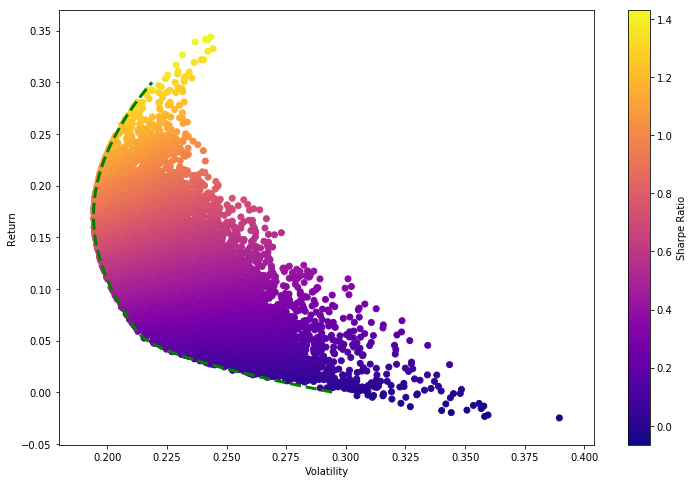

In [38]:
plt.figure(figsize=(12,8))
plt.scatter(vol_arr,ret_arr,c=sharpe_arr,cmap='plasma')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')



# Add frontier line
plt.plot(frontier_volatility,frontier_y,'g--',linewidth=3)